# Autocorrelation of Eye Tracking Data
This notebook calculates the autocorrelation of raw eye tracking data. 

Objectives:
* Autocorrelation plot showing time points with especially high correlation within the time series of data

## Configuration

In [ ]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

### Check for missing packages

In [ ]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* Scikit-image (`scikit-image`) for some image manipulation
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Dlib (`dlib`) providing the HOG face detector
* OpenCV (`opencv`) for real time applications
* Imutils (`imutils`) for image manipulation with OpenCV

Running the following cell will create a file `graphs.yml` that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.


In [ ]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

### Environment Creation

To create the environment, open the. terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
```sh
conda env create -f graphs.yml
```
After running this command you have to activate the environment (Linux/MacOS: `conda activate graphs`, Windows: `activate graphs`) and then reopen the notebook in that environment.

# Main part
### Imports and directory definition
The data directory is adjusted to the folder arrangedment of the github repo. Adjust if necessary.

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nX
import glob
from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import argrelextrema
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



OG_DATA_PATH = './'
DATA_PATH = './EyesOnScreen/'
PROCESSED_DATA_PATH = './Results/Autocorrelation/'

## Autocorrelation Part

### Loading
* Loading in the EyesOnScreen data (the ET based hit coordinates on the HMD screen) consisting of X and Y coordinates.

### Calculation
* Using the statsmodels acf autocorrelation function to calculate the autocorrelation for every time shift of the coordinate series (for each coordinate separately).
* I save these into a table.
* Afterwards, using the 10 second mark, calculating a measure of variance for all following extrema

### Plotting
* Plotting the autocorrelation plot of each coordinate separately

### Saving
* Saving the plot and autocorrelation table. 

In [ ]:
df = pd.concat(map(pd.read_csv,glob.glob(DATA_PATH + '/*.txt')))

In [ ]:
subjectdata = glob.glob(DATA_PATH + '/*.txt')

In [2]:
# data in local folder 
subjectdata = glob.glob(DATA_PATH + '/*.txt')

# initialising dataframe 
autocorr_data = pd.DataFrame()

# loading the subject data going through the local folder
for sub in subjectdata:
    # read the file and get rid of the brackets
    data = pd.read_csv(sub, names=['X','Y']) 
    data['X'] =  data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
    data['X'] = data['X'].astype('float')
    data['Y'] =  data['Y'].apply(lambda x: x.replace('(','').replace(')','')) 
    data['Y'] = data['Y'].astype('float')
    data_OG_size = data.shape[0]
    
    # only take coordinates in the interval [0,1[ (thereby also removing 0 entries)
    data = data[(data.X>0) & (data.X<=1)]
    data = data[(data.Y>0) & (data.Y<=1)]
    data_processed_size = data.shape[0]
    
    removedr = data_OG_size - data_processed_size
    proportion = removedr/data_OG_size*100
    
    print('{}: Removed rows outside interval: {} - Proportion: {}%'.format(sub, removedr, np.int(proportion)))
    
    # normalising the vector coordinates to unit length
    #data = pd.DataFrame(normalize([data.X,data.Y]).T, columns=['X','Y'])
    
    # adding a time column to the dataframe
    data['time'] = data.index*0.03/60.0

    # calculating the autocorrelation for each coordinate list with one lag per frame
    autoc_X = acf(data['X'],nlags=len(data['X'])-1)
    autoc_Y = acf(data['Y'],nlags=len(data['Y'])-1)
    
    # Calculating the median of absolute values on the first 10 second intervall
    med_abs_X_10 = np.median(np.absolute(autoc_X[1:300]))
    # Calculating the maximum absolute correlation value on the rest of the lag shift list
    max_abs_end = np.max(np.absolute(autoc_X[301::]))
    # The standard deviation in the first 10 sec interval
    std_x_10 = np.std(autoc_X[1:300])
    # The standard deviation from 10 sec til end
    std_end = np.std(autoc_X[301::])
    # filling the dataframe with each subject data point
    autocorr_data = autocorr_data.append(\
                                         {'Abs First Int': med_abs_X_10, \
                                          'Abs til end': max_abs_end,\
                                          'STD First Int': std_x_10, \
                                          'STD til end': std_end},\
                                          ignore_index=True)




    # Plotting 
    # first of all, plotting the coordinates on screen in a scatter plot
 #   plt.figure(figsize=(10,10))
 #   plt.title("Eyes on Screen Coordinates with middle point")
 #   plt.scatter(data['X'],data['Y'],s=0.1)
 #   plt.scatter(0.5,0.5,s=200)
 #   plt.xlim([0,1])
 #   plt.ylim([0,1])
 #   if(autoc_X.size == autoc_Y.size):
 #       plt.figure(figsize=(20,20))
#
 #       # Subplot X corr x unlimited
 #       plt.subplot(4,1,1)
 #       plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=2)
 #       plt.xlabel('Time (min)',fontsize=20)
 #       plt.ylabel('Correlation (x)',fontsize=20)
 #       plt.xlim([0,np.max(data['time'])])
 #       # add a line at 10 second mark
 #       plt.axvline(x=0.1666666,c='k',linewidth=1)
#
 #       # Subplot X corr x limited
 #       plt.subplot(4,1,2)
 #       plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=3)
 #       plt.xlabel('Time (min)',fontsize=20)
 #       plt.ylabel('Correlation (x)',fontsize=20)
 #       plt.xlim([0,1])
 #       # add a line at 10 second mark
 #       plt.axvline(x=0.1666666,c='k',linewidth=1)
#
 #       # Subplot Y corr x unlimited
 #       plt.subplot(4,1,3)
 #       plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=2)
 #       plt.xlabel('Time (min)',fontsize=20)
 #       plt.ylabel('Correlation (y)',fontsize=20)
 #       plt.xlim([0,np.max(data['time'])])
 #       # add a line at 10 second mark
 #       plt.axvline(x=0.1666666,c='k',linewidth=1)
#
 #       # Subplot Y corr x limited
 #       plt.subplot(4,1,4)
 #       plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=3)
 #       plt.xlabel('Time (min)',fontsize=20)
 #       plt.ylabel('Correlation (y)',fontsize=20)
 #       plt.xlim([0,1])
 #       # add a line at 10 second mark
 #       plt.axvline(x=0.1666666,c='k',linewidth=1)
 #   else:
 #       disp('The sizes of autocorrelation array do not match')
 #   
    
autocorr_data    

./EyesOnScreen/EyesOnScreen_VP8258.txt: Removed rows outside interval: 9252 - Proportion: 16%
./EyesOnScreen/EyesOnScreen_VP4502.txt: Removed rows outside interval: 12283 - Proportion: 21%
./EyesOnScreen/EyesOnScreen_VP3668.txt: Removed rows outside interval: 6259 - Proportion: 11%
./EyesOnScreen/EyesOnScreen_VP4470.txt: Removed rows outside interval: 4138 - Proportion: 7%
./EyesOnScreen/EyesOnScreen_VP8466.txt: Removed rows outside interval: 12816 - Proportion: 23%
./EyesOnScreen/EyesOnScreen_VP8834.txt: Removed rows outside interval: 7050 - Proportion: 12%
./EyesOnScreen/EyesOnScreen_VP3430.txt: Removed rows outside interval: 17590 - Proportion: 31%
./EyesOnScreen/EyesOnScreen_VP7670.txt: Removed rows outside interval: 10388 - Proportion: 18%
./EyesOnScreen/EyesOnScreen_VP1002.txt: Removed rows outside interval: 16745 - Proportion: 30%
./EyesOnScreen/EyesOnScreen_VP6387.txt: Removed rows outside interval: 12281 - Proportion: 19%
./EyesOnScreen/EyesOnScreen_VP5507.txt: Removed rows ou

,Abs First Int,Abs til end,STD First Int,STD til end
0,0.020999,0.099048,0.164652,0.014500
1,0.058035,0.055218,0.145345,0.014039
2,0.045895,0.061449,0.137026,0.012791
3,0.014441,0.061793,0.159006,0.013729
4,0.017230,0.051998,0.155145,0.013124
5,0.037561,0.066395,0.145141,0.014597
6,0.085627,0.073765,0.153536,0.015753
7,0.042356,0.070723,0.156420,0.015389
8,0.057509,0.072423,0.157566,0.017462
9,0.030245,0.083267,0.161432,0.016722


(0.0, 1.0)

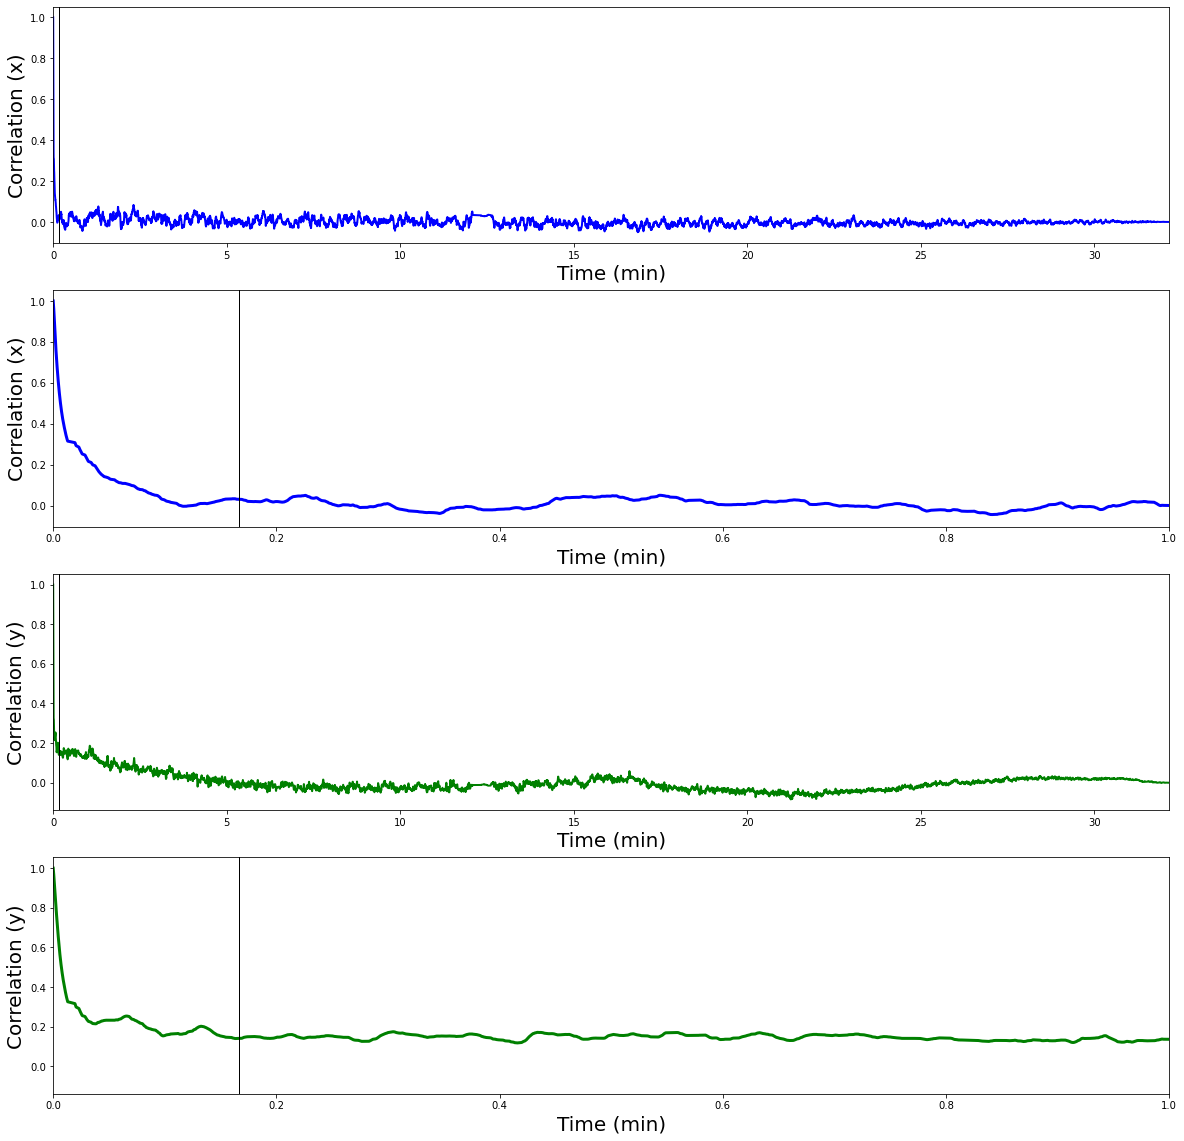

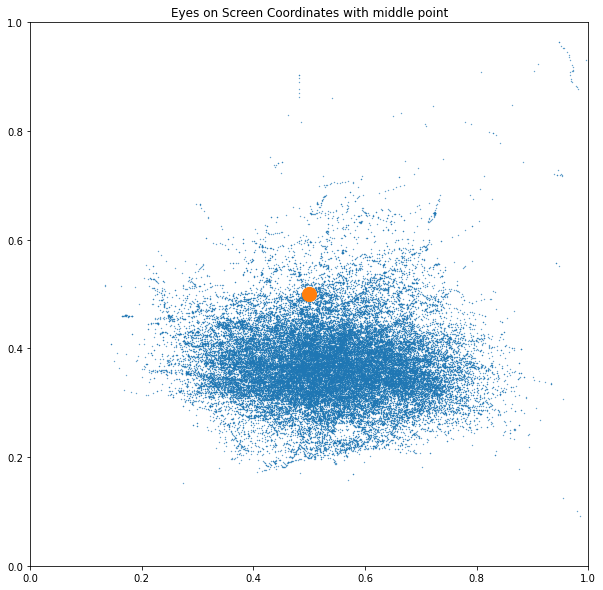

In [3]:
data = pd.read_csv(DATA_PATH + 'EyesOnScreen_VP6387.txt', names=['X','Y']) 
data['X'] =  data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
data['X'] = data['X'].astype('float')
data['Y'] =  data['Y'].apply(lambda x: x.replace('(','').replace(')','')) 
data['Y'] = data['Y'].astype('float')

#data = data[data.values.sum(axis=1) != 0] 

#data = data[data.values.sum(axis=1) > 0]
#data = data[data.values.sum(axis=1) <= 1]

#data = data[(data.values.sum(axis=1) > 0) & (data.values.sum(axis=1) <= 1)]

# only take coordinates in the interval [0,1[
data = data[(data.X>0) & (data.X<=1)]
data = data[(data.Y>0) & (data.Y<=1)]

#data = pd.DataFrame(normalize([data.X,data.Y]).T, columns=['X','Y'])

data['time'] = data.index*0.03/60.0

autoc_X = acf(data['X'],nlags=len(data['X'])-1)
autoc_Y = acf(data['Y'],nlags=len(data['Y'])-1)


med_abs_X_10 = np.median(np.absolute(autoc_X[1:300]))
max_abs_end = np.max(np.absolute(autoc_X[301::]))

autocorr_data = pd.DataFrame()
autocorr_data = autocorr_data.append({'Median Abs First Intervall': med_abs_X_10, 'Abs til end': max_abs_end}, ignore_index=True)

labels = ['X','Y']
# Plotting 
if(autoc_X.size == autoc_Y.size):
    plt.figure(figsize=(20,20))
    
    # Subplot X corr x unlimited
    plt.subplot(4,1,1)
    plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=2)
    plt.xlabel('Time (min)',fontsize=20)
    plt.ylabel('Correlation (x)',fontsize=20)
    plt.xlim([0,np.max(data['time'])])
    # add a line at 10 second mark
    plt.axvline(x=0.1666666,c='k',linewidth=1)
    
    # Subplot X corr x limited
    plt.subplot(4,1,2)
    plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=3)
    plt.xlabel('Time (min)',fontsize=20)
    plt.ylabel('Correlation (x)',fontsize=20)
    plt.xlim([0,1])
    # add a line at 10 second mark
    plt.axvline(x=0.1666666,c='k',linewidth=1)
    
    # Subplot Y corr x unlimited
    plt.subplot(4,1,3)
    plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=2)
    plt.xlabel('Time (min)',fontsize=20)
    plt.ylabel('Correlation (y)',fontsize=20)
    plt.xlim([0,np.max(data['time'])])
    # add a line at 10 second mark
    plt.axvline(x=0.1666666,c='k',linewidth=1)
    
    # Subplot Y corr x limited
    plt.subplot(4,1,4)
    plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=3)
    plt.xlabel('Time (min)',fontsize=20)
    plt.ylabel('Correlation (y)',fontsize=20)
    plt.xlim([0,1])
    # add a line at 10 second mark
    plt.axvline(x=0.1666666,c='k',linewidth=1)
else:
    disp('The sizes of autocorrelation array do not match')

    
   
plt.figure(figsize=(10,10))
plt.title("Eyes on Screen Coordinates with middle point")
plt.scatter(data['X'],data['Y'],s=0.1)
plt.scatter(0.5,0.5,s=200)
plt.xlim([0,1])
plt.ylim([0,1]) 

# der erste null durchgang (x koordinate) # Das max des Betrags von allen werten mit höherer verschiebung (irgendein varianzmaß)

In [ ]:
maxima_X = argrelextrema(np.array(data.X), np.greater)
maxima_Y = argrelextrema(np.array(data.Y), np.greater)
maxima_Z = argrelextrema(np.array(data.Z), np.greater)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(maxima_X[0])
plt.title("X coord")
plt.ylabel("Local Maximum Index")
plt.xlabel("Local Maximum")
plt.subplot(1,3,2)
plt.plot(maxima_Y[0])
plt.title("Y coord")
plt.ylabel("Local Maximum Index")
plt.xlabel("Local Maximum")
plt.subplot(1,3,3)
plt.plot(maxima_Z[0])
plt.title("Z coord")
plt.ylabel("Local Maximum Index")
plt.xlabel("Local Maximum")
plt.show()

X_x = maxima_X[0]
X_y = np.arange(0,len(X_x))
Y_x = maxima_Y[0]
Y_y = np.arange(0,len(Y_x))
Z_x = maxima_Z[0]
Z_y = np.arange(0,len(Z_x))

m_X = (len(X_x) * np.sum(X_x*X_y) - np.sum(X_x) * np.sum(X_y))/(len(X_x)*np.sum(X_x*X_x) - np.sum(X_x) ** 2)
m_Y = (len(Y_x) * np.sum(Y_x*Y_y) - np.sum(Y_x) * np.sum(Y_y))/(len(X_x)*np.sum(Y_x*Y_x) - np.sum(Y_x) ** 2)
m_Z = (len(Z_x) * np.sum(Z_x*Z_y) - np.sum(Z_x) * np.sum(Z_y))/(len(X_x)*np.sum(Z_x*Z_x) - np.sum(Z_x) ** 2)
    
#print("The best fit slope of X is: ", m_X)
print("The mean maxima jump (in seconds) is: ", m_X/0.03)
#print("The best fit slope of Y is: ", m_Y)
print("The mean maxima jump (in seconds) is: ", m_Y/0.03)
#print("The best fit slope of Z is: ", m_Z)
print("The mean maxima jump (in seconds) is: ", m_Z/0.03)
print("Overall mean jump (in seconds):", ((m_X/0.03)+(m_Y/0.03)+(m_Z/0.03))/3)

In [ ]:
soa = np.zeros((data.shape[0],6))

for i in range(0,data.shape[0],1800):
    soa[i,3] = data.X[i]
    soa[i,4] = data.X[i]
    soa[i,5] = data.X[i]

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-.008, .008])
ax.set_ylim([-.008, .008])
ax.set_zlim([-.008, .008])
plt.show()